In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


batch_size = 128
num_classes = 10
epochs = 20

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


11493376/11490434 [==============================] - 64s 6us/step
60000 train samples
10000 test samples


In [2]:
print('data.shape\t',x_train.shape, '\ntarget.shape \t',y_train.shape)

data.shape	 (60000, 784) 
target.shape 	 (60000, 10)


In [16]:
from keras.regularizers import l2
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout


"""
using the functional API and setup dropout this way: Dropout(p)(input_tensor, training=True) in the call of 
the Dropout layer for both training and testing phase.

Ref: https://github.com/keras-team/keras/issues/9412
ref2: (Yarin Gal: Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning)
      https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py 
"""

def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

def generate_dropout_model(mc=False, act="relu"):
    # We construct the network
    inp = Input(shape=(784,))
    x = get_dropout(inp, p=0.025, mc=mc)
    x = Dense(1000, activation=act)(x)
    x = get_dropout(x, p=0.05, mc=mc)
    x = Dense(100, activation=act)(x)
    x = get_dropout(x, p=0.05, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [17]:
mc_model = generate_dropout_model(mc=True, act="relu")
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 158us/step - loss: 0.2300 - accuracy: 0.9323 - val_loss: 0.1060 - val_accuracy: 0.9662
Epoch 2/20
60000/60000 [==============================] - 9s 158us/step - loss: 0.0882 - accuracy: 0.9730 - val_loss: 0.0895 - val_accuracy: 0.9711
Epoch 3/20
60000/60000 [==============================] - 9s 156us/step - loss: 0.0570 - accuracy: 0.9821 - val_loss: 0.0755 - val_accuracy: 0.9767
Epoch 4/20
60000/60000 [==============================] - 10s 168us/step - loss: 0.0432 - accuracy: 0.9855 - val_loss: 0.0707 - val_accuracy: 0.9782
Epoch 5/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.0688 - val_accuracy: 0.9794
Epoch 6/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0282 - accuracy: 0.9903 - val_loss: 0.0739 - val_accuracy: 0.9778
Epoch 7/20
60000/60000 [==============================] - 

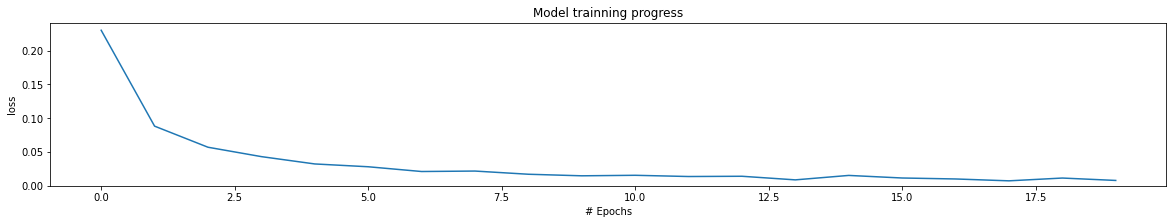

Test loss: 0.08640040498570238
Test accuracy: 0.9825999736785889


In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(h_mc.history['loss'])
plt.title('Model trainning progress')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.ylim(0)
plt.show()


score = mc_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [19]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [02:15<00:00,  3.69it/s]


In [21]:
from sklearn.metrics import accuracy_score
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs))) #taking the average

MC accuracy: 98.3%


In [23]:
import numpy as np
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 98.5%


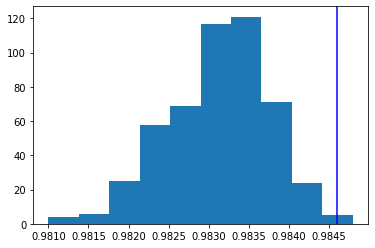

In [24]:
#distributions of the monte carlo predictions and in blue line the prediction of the ensemble.
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");

In [29]:
idx = 300

p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 4
true label: 4

class: 0; proba: 0.0%; var: 0.00% 
class: 1; proba: 0.0%; var: 0.11% 
class: 2; proba: 0.1%; var: 0.57% 
class: 3; proba: 0.0%; var: 0.00% 
class: 4; proba: 99.8%; var: 0.60% 
class: 5; proba: 0.0%; var: 0.00% 
class: 6; proba: 0.0%; var: 0.05% 
class: 7; proba: 0.0%; var: 0.02% 
class: 8; proba: 0.0%; var: 0.00% 
class: 9; proba: 0.0%; var: 0.00% 


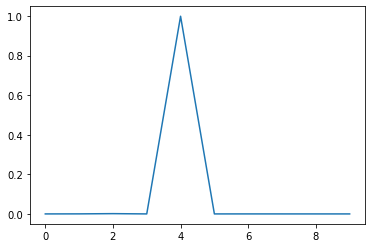

In [30]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);